# More advanced plotting with pandas/Matplotlib

```{attention}
Finnish university students are encouraged to use the CSC Notebooks platform.<br/>
<a href="https://notebooks.csc.fi/"><img alt="CSC badge" src="https://img.shields.io/badge/launch-CSC%20notebook-blue.svg" style="vertical-align:text-bottom"></a>
```

```{note}
We do not recommended using Binder for this lesson.
```

At this point you should know the basics of making plots with pandas and the Matplotlib module. Now we will expand on our basic plotting skills to learn how to create more advanced plots. In this part, we will show how to visualize data using pandas/Matplotlib and create plots like the example below.

![Subplot example in Matplotlib](img/subplots.png)

## Input data

In this part of the lesson we'll continue working with the same weather observation data from the Helsinki-Vantaa airport used in the first part of the lesson (downloaded from the [NOAA online databases](https://www.ncei.noaa.gov/cdo-web/)).

If you are working with Jupyter Lab installed on your own computer, Lesson 6 covered [how to download the weather data](https://geo-python-site.readthedocs.io/en/latest/notebooks/L6/advanced-data-processing-with-pandas.html#downloading-the-data). **Those using the CSC Notebooks do not need to download the data**.

## Getting started

Let's start again by importing the libraries we'll need.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

### Loading the data

Now we'll load the data just as we did in the first part of the lesson:

- Set whitespace as the delimiter
- Specify the no data values
- Specify a subset of columns
- Parse the `'YR--MODAHRMN'` column as a datetime index

Reading in the data might take a few moments.

In [6]:
# IGNORE THIS CELL
# It is only needed to generate the course website
fp = r"data/029740.txt"

In [8]:
data = pd.read_csv(
    fp,
    delim_whitespace=True,
    na_values=["*", "**", "***", "****", "*****", "******"],
    usecols=["YR--MODAHRMN", "TEMP", "MAX", "MIN"],
    parse_dates=["YR--MODAHRMN"],
    index_col="YR--MODAHRMN",
)

/var/folders/j3/1_g39gs501q6lwzqcx234sfm0000gn/T/ipykernel_16764/4042178882.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(


In [10]:
print(f"Number of rows: {len(data)}")

Number of rows: 257672


As you can see, we are dealing with a relatively large data set.

Let's have a closer look at the time first rows of data.

In [6]:
data.head()

,TEMP,MAX,MIN
YR--MODAHRMN,,,
1952-01-01 00:00:00,36.0,NaN,NaN
1952-01-01 06:00:00,37.0,NaN,34.0
1952-01-01 12:00:00,39.0,NaN,NaN
1952-01-01 18:00:00,36.0,39.0,NaN
1952-01-02 00:00:00,36.0,NaN,NaN


Let's rename the `'TEMP'` column as `TEMP_F`, since we'll later convert our temperatures from Fahrenheit to Celsius.

In [12]:
new_names = {"TEMP": "TEMP_F"}
data = data.rename(columns=new_names)

We can now check the first rows of data again to confirm successful renaming.

In [14]:
data.head()

,TEMP_F,MAX,MIN
YR--MODAHRMN,,,
1952-01-01 00:00:00,36.0,NaN,NaN
1952-01-01 06:00:00,37.0,NaN,34.0
1952-01-01 12:00:00,39.0,NaN,NaN
1952-01-01 18:00:00,36.0,39.0,NaN
1952-01-02 00:00:00,36.0,NaN,NaN


## Preparing the data

First, we have to deal with no data values. Let's check how many no data values we have.

In [20]:
print(f"Number of no data values per column:\n{data.isna().sum()}")

Number of no data values per column:
TEMP_F      1644
MAX       249697
MIN       249701
dtype: int64


So, we have 3579 missing values in the TEMP_F column, which we can now remove. We do not need to worry about the no data values in the `'MAX'` and `'MIN'` columns since we won't be using them for plotting. 

We can remove rows from our DataFrame where `'TEMP_F'` is missing values using the `dropna()` method as shown below.

In [22]:
data.dropna(subset=["TEMP_F"], inplace=True)

In [24]:
print(f"Number of rows after removing no data values: {len(data)}")

Number of rows after removing no data values: 256028


That's better.

### Check your understanding

What would happen if we removed all rows with any no data values from our data (also considering no data values in the `MAX` and `MIN` columns)?

In [26]:
# After removing all no data values we are left with only a fraction of the original data.
# Note! Here we are *not* applying .dropna() with the "inplace" parameter
#       so we are not making any permanent changes to our DataFrame.
print(f"If we drop all rows with no data values we have {len(data.dropna())} rows left in our DataFrame.")
print(f"If we drop only the missing TEMP_F values we have {len(data)} rows in our DataFrame.")

If we drop all rows with no data values we have 6601 rows left in our DataFrame.
If we drop only the missing TEMP_F values we have 256028 rows in our DataFrame.


### Converting temperatures to Celsius

Now that we have loaded our data, we can convert the values of temperature in Fahrenheit to Celsius, like we have in earlier lessons.

In [28]:
data["TEMP_C"] = (data["TEMP_F"] - 32.0) / 1.8

Let's check how our DataFrame looks like at this point:

In [30]:
data.head()

,TEMP_F,MAX,MIN,TEMP_C
YR--MODAHRMN,,,,
1952-01-01 00:00:00,36.0,NaN,NaN,2.222222
1952-01-01 06:00:00,37.0,NaN,34.0,2.777778
1952-01-01 12:00:00,39.0,NaN,NaN,3.888889
1952-01-01 18:00:00,36.0,39.0,NaN,2.222222
1952-01-02 00:00:00,36.0,NaN,NaN,2.222222


## Using subplots

Let's continue working with the weather data and learn how to use *subplots*. Subplots are figures where you have multiple plots in different panels of the same figure, like what was shown at the start of the lesson.

### Extracting seasonal temperatures

We can start by selecting data from different seasons of the year in 2012/2013:

- Winter (December 2012 - February 2013)
- Spring (March 2013 - May 2013)
- Summer (June 2013 - August 2013)
- Autumn (Septempber 2013 - November 2013)

In [32]:
winter = data.loc[(data.index >= "201212010000") & (data.index < "201303010000")]
winter_temps = winter["TEMP_C"]

spring = data.loc[(data.index >= "201303010000") & (data.index < "201306010000")]
spring_temps = spring["TEMP_C"]

summer = data.loc[(data.index >= "201306010000") & (data.index < "201309010000")]
summer_temps = summer["TEMP_C"]

autumn = data.loc[(data.index >= "201309010000") & (data.index < "201312010000")]
autumn_temps = autumn["TEMP_C"]

Now we can plot our data to see how the different individual seasons look.

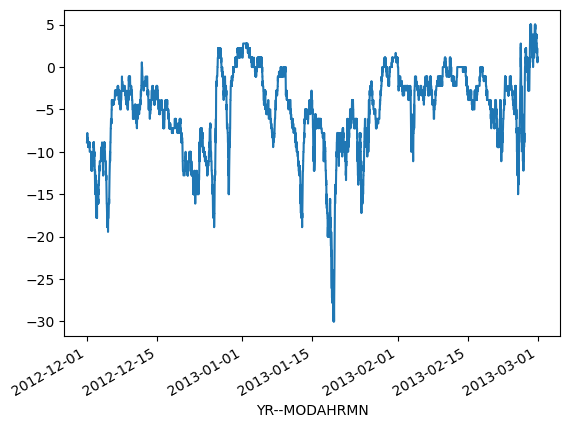

In [34]:
ax1 = winter_temps.plot()

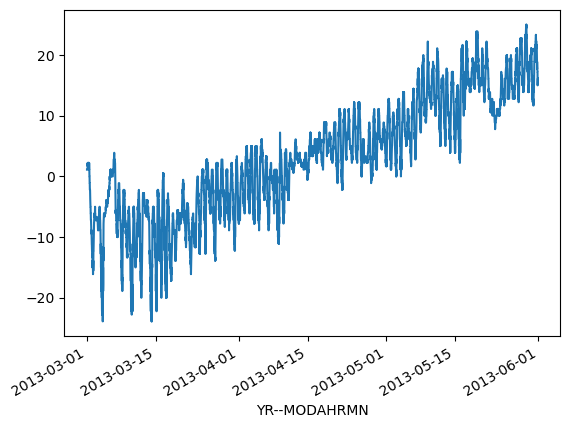

In [36]:
ax2 = spring_temps.plot()

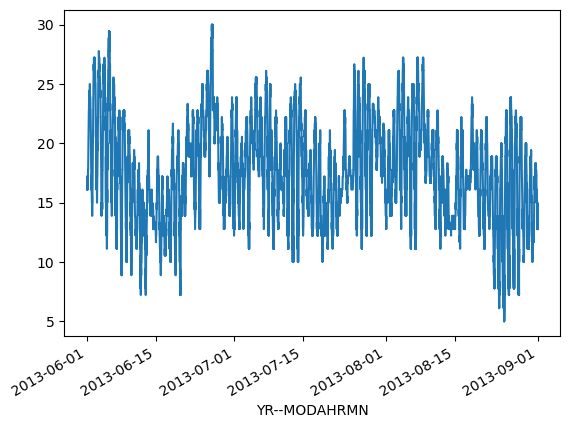

In [38]:
ax3 = summer_temps.plot()

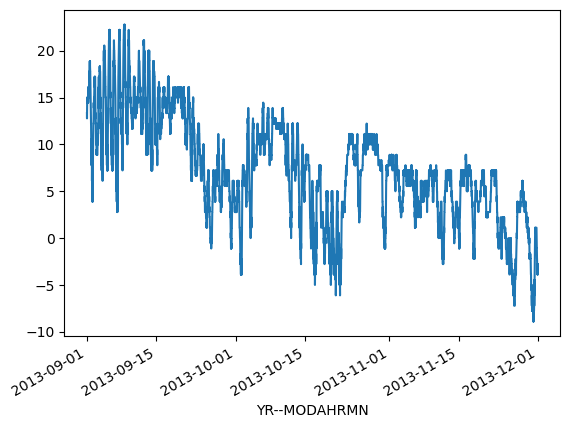

In [40]:
ax4 = autumn_temps.plot()

OK, so from these plots we can already see that the temperatures the four seasons are quite different, which is rather obvious of course. It is important to also notice that the scale of the *y*-axis changes in these four plots. If we would like to compare different seasons to each other we need to make sure that the temperature scale is similar in the plots for each season.

### Finding data bounds

Out next goal is to set our *y*-axis limits so that the upper limit is the maximum temperature + 5 degrees in our data (full year), and the lowest is the minimum temperature - 5 degrees.

In [42]:
# Find lower limit for y-axis
min_temp = min(
    winter_temps.min(), spring_temps.min(), summer_temps.min(), autumn_temps.min()
)
min_temp = min_temp - 5.0

# Find upper limit for y-axis
max_temp = max(
    winter_temps.max(), spring_temps.max(), summer_temps.max(), autumn_temps.max()
)
max_temp = max_temp + 5.0

# Print y-axis min, max
print(f"Min: {min_temp}, Max: {max_temp}")

Min: -35.0, Max: 35.0


We can now use this temperature range to standardize the y-axis range on our plots.

### Creating our first set of subplots

We can now continue and see how we can plot all these different plots in the same figure. First, we can create a 2x2 panel for our visualization using Matplotlib’s `subplots()` function where we specify how many rows and columns we want to have in our figure. We can also specify the size of our figure with `figsize` parameter as we have seen earlier with pandas. As a reminder, `figsize` takes the `width` and `height` values (in inches!) as inputs.

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

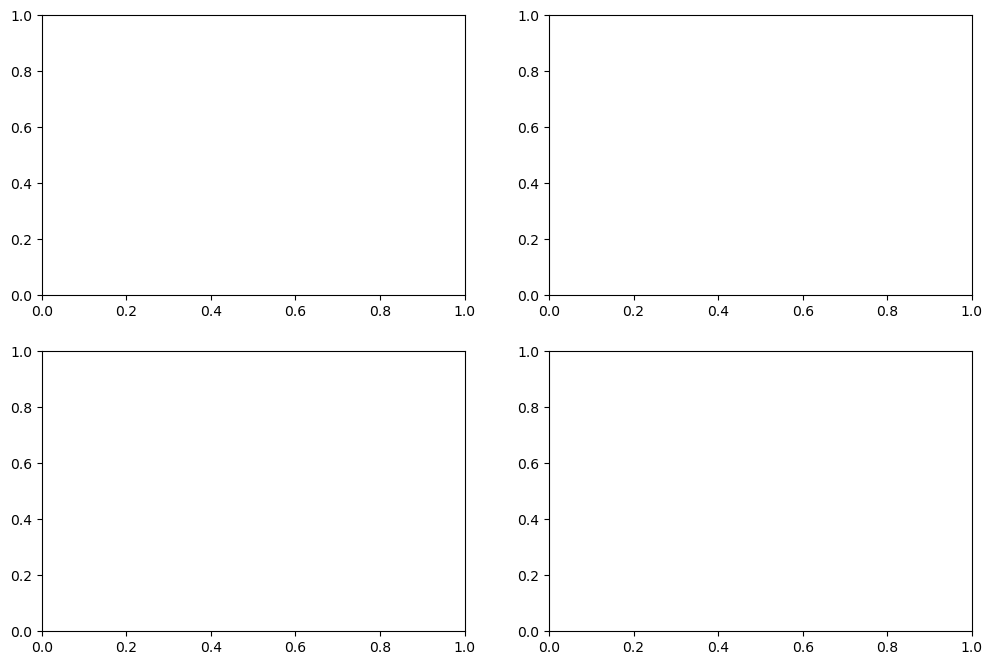

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes

You can see that as a result we have now a list containing two nested lists where the first one contains the axis for column 1 and 2 on **row 1** and the second list contains the axis for columns 1 and 2 for **row 2**.

We can split these axes into their own variables so it is easier to work with them.

In [46]:
ax11 = axes[0][0]
ax12 = axes[0][1]
ax21 = axes[1][0]
ax22 = axes[1][1]

Now we have four variables for our plot axes that we can use for the different panels in our figure. Next we will use them to plot the seasonal data. Let's begin by plotting the seasons, and use different colors for the lines and specify the *y*-axis range to be the same for all subplots. We can do this using what we know and some parameters below:

- The `c` parameter changes the color of the line. Matplotlib has a [large list of named colors](https://matplotlib.org/stable/gallery/color/named_colors.html) you can consult to customize your color scheme.
- The `lw` parameter controls the thickness of the lines
- The `ylim` parameter controls the y-axis range

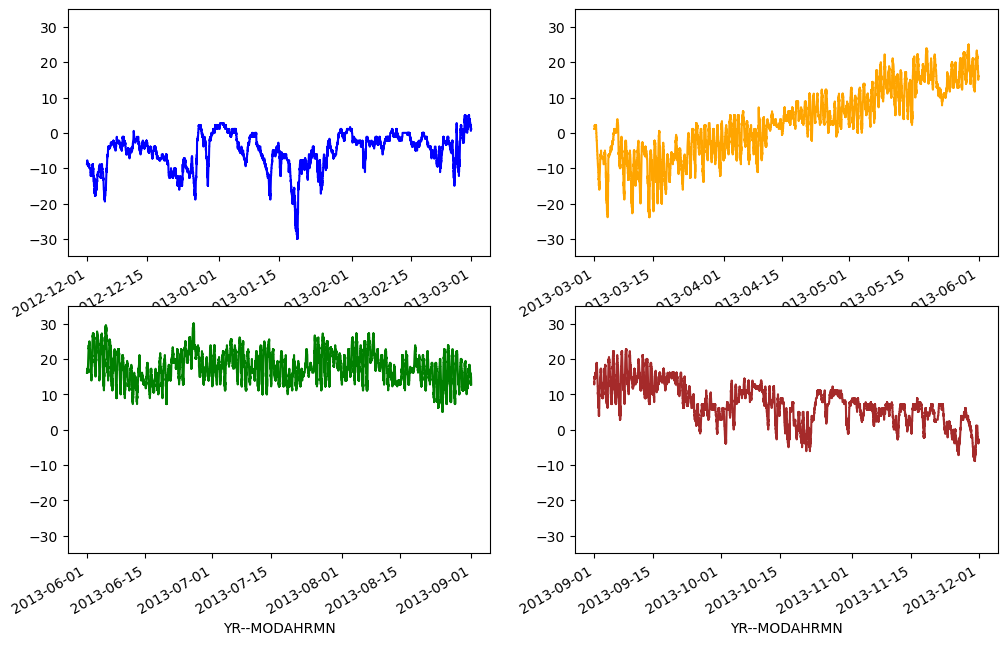

In [48]:
# Set the plot line width
line_width = 1.5

# Plot data
winter_temps.plot(ax=ax11, c="blue", lw=line_width, ylim=[min_temp, max_temp])
spring_temps.plot(ax=ax12, c="orange", lw=line_width, ylim=[min_temp, max_temp])
summer_temps.plot(ax=ax21, c="green", lw=line_width, ylim=[min_temp, max_temp])
autumn_temps.plot(ax=ax22, c="brown", lw=line_width, ylim=[min_temp, max_temp])

# Display the figure
fig

Great, now we have all four plots in same figure! However, you can see that there are some problems with our *x*-axis labels and a few missing plot items that we can add. Let's do that below.

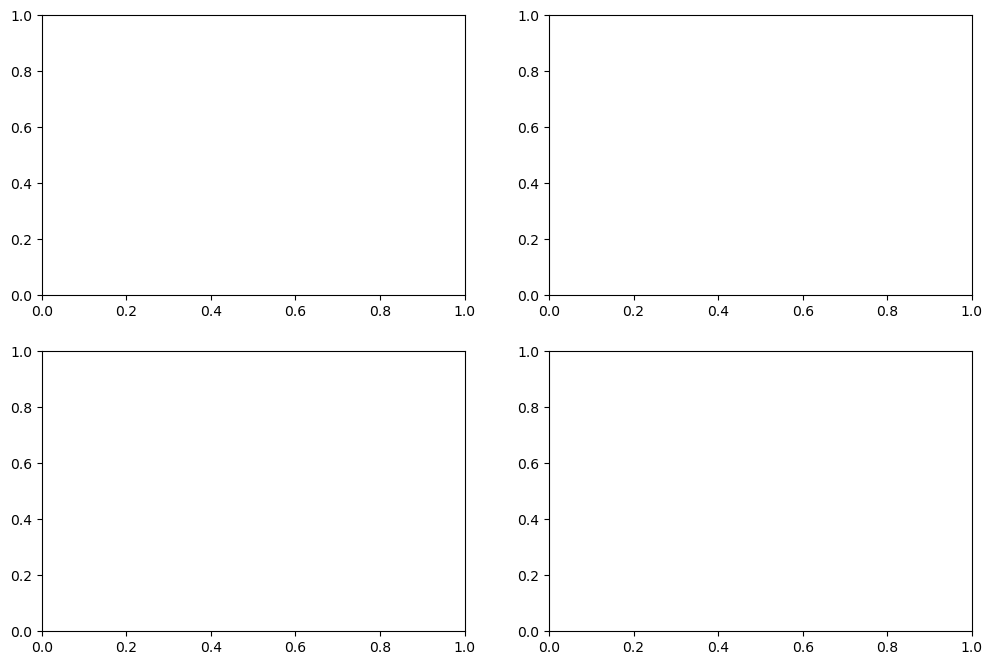

In [24]:
# Create the new figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Rename the axes for ease of use
ax11 = axes[0][0]
ax12 = axes[0][1]
ax21 = axes[1][0]
ax22 = axes[1][1]

Now, we'll add our seasonal temperatures to the plot commands for each time period.

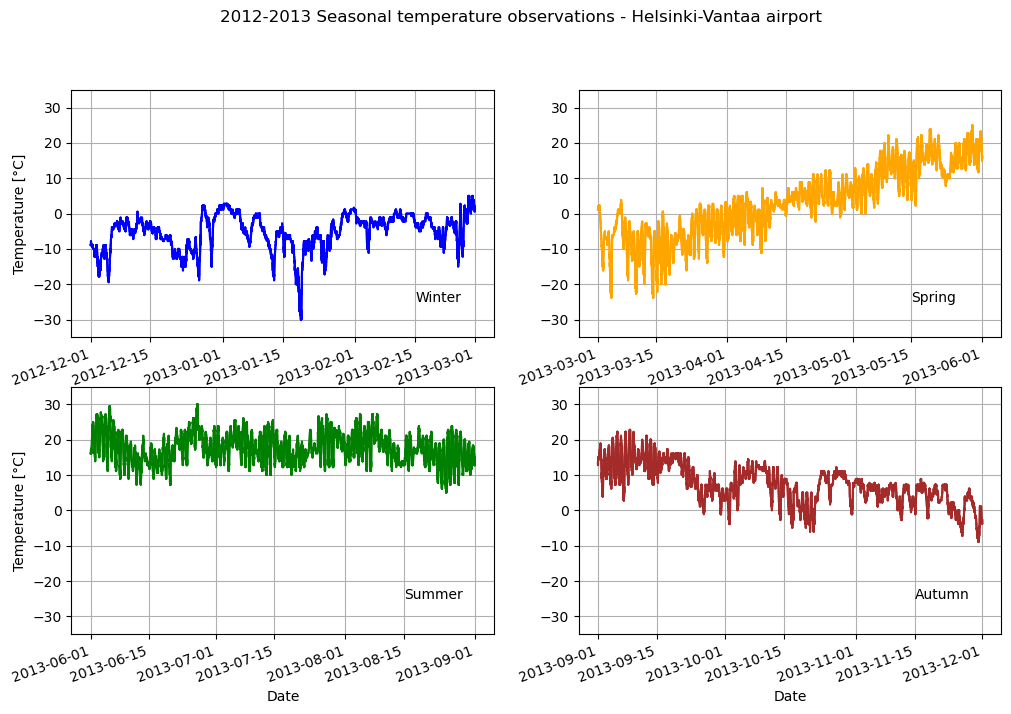

In [50]:
# Set plot line width
line_width = 1.5

# Plot data
winter_temps.plot(
    ax=ax11, c="blue", lw=line_width, ylim=[min_temp, max_temp], grid=True
)
spring_temps.plot(
    ax=ax12, c="orange", lw=line_width, ylim=[min_temp, max_temp], grid=True
)
summer_temps.plot(
    ax=ax21, c="green", lw=line_width, ylim=[min_temp, max_temp], grid=True
)
autumn_temps.plot(
    ax=ax22, c="brown", lw=line_width, ylim=[min_temp, max_temp], grid=True
)

# Set figure title
fig.suptitle("2012-2013 Seasonal temperature observations - Helsinki-Vantaa airport")

# Rotate the x-axis labels so they don't overlap
plt.setp(ax11.xaxis.get_majorticklabels(), rotation=20)
plt.setp(ax12.xaxis.get_majorticklabels(), rotation=20)
plt.setp(ax21.xaxis.get_majorticklabels(), rotation=20)
plt.setp(ax22.xaxis.get_majorticklabels(), rotation=20)

# Axis labels
ax21.set_xlabel("Date")
ax22.set_xlabel("Date")
ax11.set_ylabel("Temperature [°C]")
ax21.set_ylabel("Temperature [°C]")

# Season label text
ax11.text(pd.to_datetime("20130215"), -25, "Winter")
ax12.text(pd.to_datetime("20130515"), -25, "Spring")
ax21.text(pd.to_datetime("20130815"), -25, "Summer")
ax22.text(pd.to_datetime("20131115"), -25, "Autumn")

# Display plot
fig

Not bad.

### Check your understading

Visualize only the winter and summer temperatures in a 1x2 panel figure.
Save the figure as a .png file.

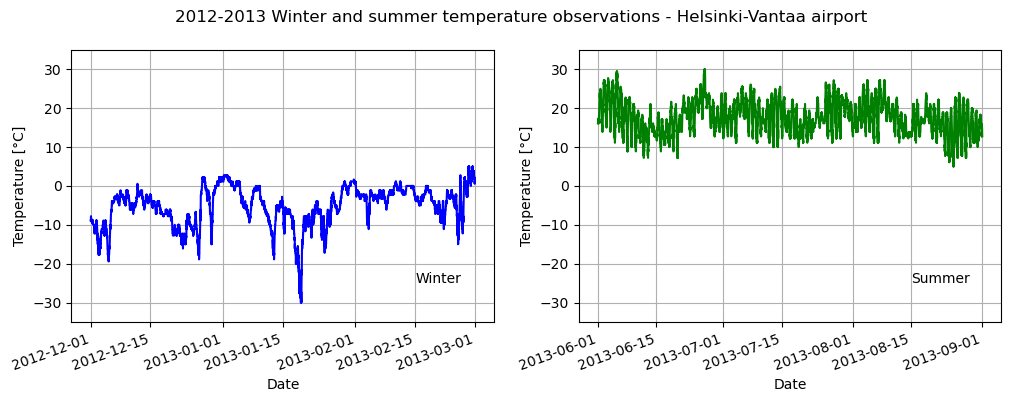

In [52]:
# Two subplots side-by-side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Set plot line width
line_width = 1.5

# Plot data
winter_temps.plot(
    ax=axs[0], c="blue", lw=line_width, ylim=[min_temp, max_temp], grid=True
)
summer_temps.plot(
    ax=axs[1], c="green", lw=line_width, ylim=[min_temp, max_temp], grid=True
)

# Set figure title
fig.suptitle(
    "2012-2013 Winter and summer temperature observations - Helsinki-Vantaa airport"
)

# Rotate the x-axis labels so they don't overlap
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=20)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=20)

# Axis labels
axs[0].set_xlabel("Date")
axs[1].set_xlabel("Date")
axs[0].set_ylabel("Temperature [°C]")
axs[1].set_ylabel("Temperature [°C]")

# Season label text
axs[0].text(pd.to_datetime("20130215"), -25, "Winter")
axs[1].text(pd.to_datetime("20130815"), -25, "Summer")

plt.savefig("HelsinkiVantaa_WinterSummer_2012-2013.png")

## Extra: pandas/Matplotlib plot style sheets

One cool thing about plotting using pandas/Matplotlib is that is it possible to change the overall appearance of your plot to one of several available plot style options very easily. Let's consider an example below using the four-panel plot we produced in this lesson.

We will start by defining the plot style, using the `'dark_background'` plot style here.

In [56]:
plt.style.use("dark_background")

There is no output from this command, but now when we create a plot it will use the `dark_background` styling. Let's see what that looks like.

Text(2013-11-15 00:00:00, -25, 'Autumn')

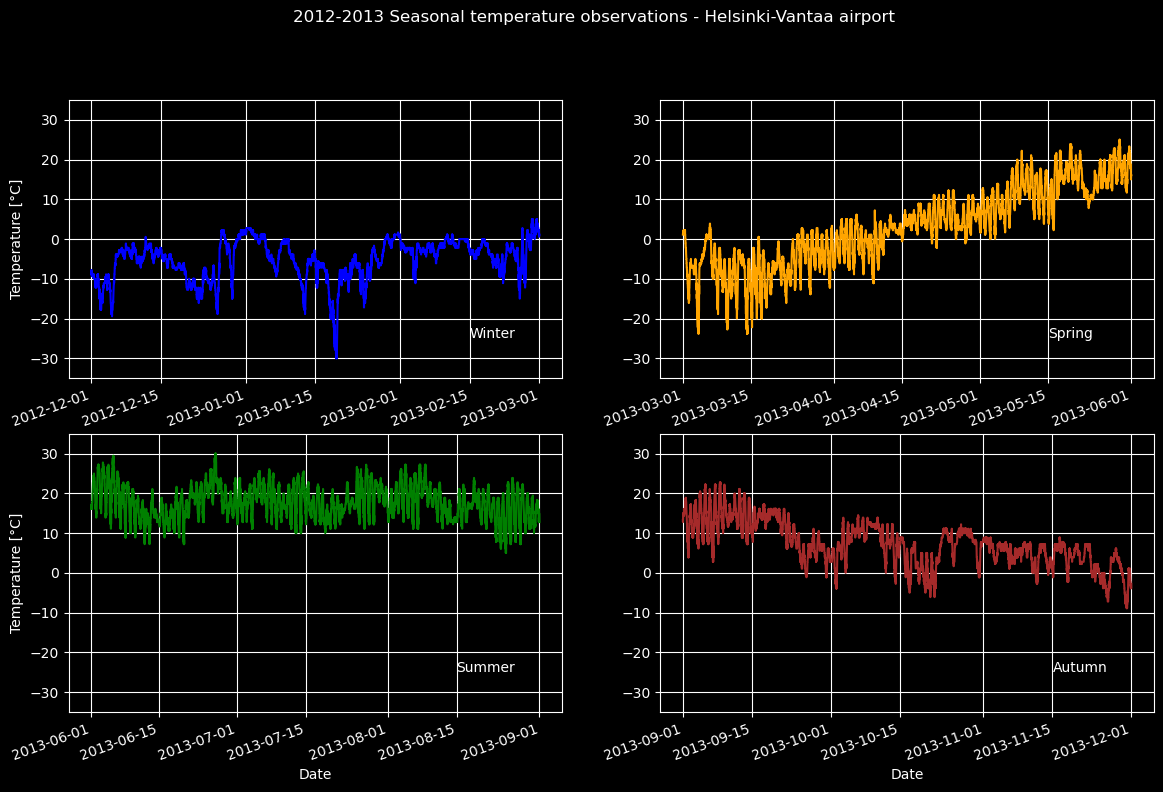

In [58]:
# Create the new figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 9))

# Rename the axes for ease of use
ax11 = axs[0][0]
ax12 = axs[0][1]
ax21 = axs[1][0]
ax22 = axs[1][1]

# Set plot line width
line_width = 1.5

# Plot data
winter_temps.plot(
    ax=ax11, c="blue", lw=line_width, ylim=[min_temp, max_temp], grid=True
)
spring_temps.plot(
    ax=ax12, c="orange", lw=line_width, ylim=[min_temp, max_temp], grid=True
)
summer_temps.plot(
    ax=ax21, c="green", lw=line_width, ylim=[min_temp, max_temp], grid=True
)
autumn_temps.plot(
    ax=ax22, c="brown", lw=line_width, ylim=[min_temp, max_temp], grid=True
)

# Set figure title
fig.suptitle("2012-2013 Seasonal temperature observations - Helsinki-Vantaa airport")

# Rotate the x-axis labels so they don't overlap
plt.setp(ax11.xaxis.get_majorticklabels(), rotation=20)
plt.setp(ax12.xaxis.get_majorticklabels(), rotation=20)
plt.setp(ax21.xaxis.get_majorticklabels(), rotation=20)
plt.setp(ax22.xaxis.get_majorticklabels(), rotation=20)

# Axis labels
ax21.set_xlabel("Date")
ax22.set_xlabel("Date")
ax11.set_ylabel("Temperature [°C]")
ax21.set_ylabel("Temperature [°C]")

# Season label text
ax11.text(pd.to_datetime("20130215"), -25, "Winter")
ax12.text(pd.to_datetime("20130515"), -25, "Spring")
ax21.text(pd.to_datetime("20130815"), -25, "Summer")
ax22.text(pd.to_datetime("20131115"), -25, "Autumn")

As you can see, the plot format has now changed to use the `dark_background` style. You can find other plot style options in the [complete list of available Matplotlib style sheets](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html). Have fun!